In [9]:
# 1. IMPORT LIBRARY
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Untuk TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models

# Untuk PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
# prompt: baca data ini /content/RegresiUTSTelkom.csv

df = pd.read_csv('/content/RegresiUTSTelkom.csv', on_bad_lines='skip', low_memory=False)

# Konversi kolom ke numerik jika memungkinkan
df = df.apply(pd.to_numeric, errors='ignore')
df.head()

/tmp/ipython-input-10-1284112937.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263



🚀 Training TensorFlow model...

🔥 Training PyTorch model...
Epoch 10/100 - Loss: 0.96
Epoch 20/100 - Loss: 0.84
Epoch 30/100 - Loss: 0.80
Epoch 40/100 - Loss: 0.76
Epoch 50/100 - Loss: 0.74
Epoch 60/100 - Loss: 0.72
Epoch 70/100 - Loss: 0.70
Epoch 80/100 - Loss: 0.69
Epoch 90/100 - Loss: 0.68
Epoch 100/100 - Loss: 0.67

📊 Evaluasi akhir:
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TensorFlow - MSE: 72.80, RMSE: 8.53, R^2: 0.3446
PyTorch - MSE: 76.85, RMSE: 8.77, R^2: 0.3082


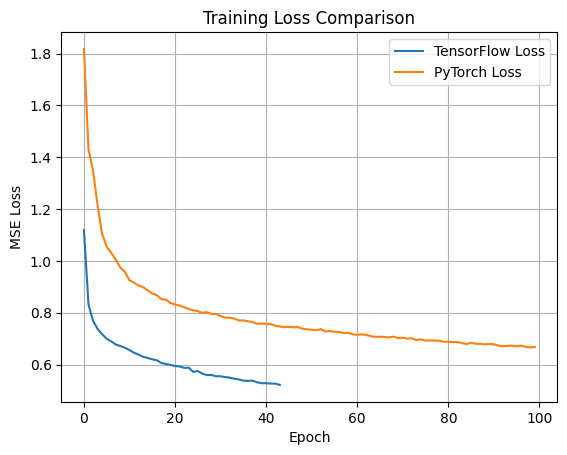

In [11]:
int_cols = df.select_dtypes(include='int').columns
target_column = int_cols[0] if len(int_cols) > 0 else df.select_dtypes(include=np.number).columns[0]
X = df.drop(columns=[target_column])
y = df[target_column]

for col in X.select_dtypes(include=np.number).columns:
    X[col] = X[col].fillna(X[col].mean())
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna(X[col].mode()[0])

y = y.dropna()
X = X.loc[y.index]

# Preprocessing pipeline
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=np.number).columns
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# Sample 10% untuk cepat
X_small = X_processed[:int(0.1 * X_processed.shape[0])]
y_small = y.iloc[:X_small.shape[0]]

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

# Normalisasi target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to array if sparse
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

# 2. TENSORFLOW MODEL
print("\n🚀 Training TensorFlow model...")
model_tf = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_tf.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_tf = model_tf.fit(X_train, y_train_scaled, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stop], verbose=0)

# 3. PYTORCH MODEL
print("\n🔥 Training PyTorch model...")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

class MLP_PyTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLP_PyTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model_torch = MLP_PyTorch(X_train_tensor.shape[1])
model_torch.apply(lambda m: nn.init.kaiming_normal_(m.weight) if isinstance(m, nn.Linear) else None)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.005)

losses_torch = []
for epoch in range(100):
    model_torch.train()
    pred = model_torch(X_train_tensor)
    loss = loss_fn(pred.squeeze(), y_train_tensor.squeeze())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_torch.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/100 - Loss: {loss.item():.2f}")

# 4. EVALUASI & PLOTTING
print("\n📊 Evaluasi akhir:")
# TensorFlow
y_pred_tf = model_tf.predict(X_test)
y_pred_tf = y_scaler.inverse_transform(y_pred_tf)

mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)
print(f"TensorFlow - MSE: {mse_tf:.2f}, RMSE: {rmse_tf:.2f}, R^2: {r2_tf:.4f}")

# PyTorch
model_torch.eval()
with torch.no_grad():
    y_pred_torch = model_torch(X_test_tensor).detach().numpy()
    y_pred_torch = y_scaler.inverse_transform(y_pred_torch)

mse_torch = mean_squared_error(y_test, y_pred_torch)
rmse_torch = np.sqrt(mse_torch)
r2_torch = r2_score(y_test, y_pred_torch)
print(f"PyTorch - MSE: {mse_torch:.2f}, RMSE: {rmse_torch:.2f}, R^2: {r2_torch:.4f}")

# Plot
plt.plot(history_tf.history['loss'], label='TensorFlow Loss')
plt.plot(losses_torch, label='PyTorch Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.show()



##📌 Perbandingan Model MLP Regresi menggunakan TensorFlow dan PyTorch

1. 🧠 Penjelasan Setiap Model

A. Model TensorFlow

Model yang dibangun menggunakan TensorFlow terdiri dari beberapa lapisan fully connected (Dense) dengan arsitektur sebagai berikut:
- Dense layer 128 neuron + ReLU + BatchNormalization + Dropout 0.3
- Dense layer 64 neuron + ReLU + BatchNormalization + Dropout 0.3
- Dense layer 32 neuron + ReLU
- Output layer 1 neuron (tanpa aktivasi karena regresi)

Model dikompilasi menggunakan optimizer Adam dan fungsi loss Mean Squared Error (MSE). Selain itu, digunakan EarlyStopping untuk menghentikan pelatihan secara otomatis jika tidak ada perbaikan pada validation loss selama 10 epoch.

B. Model PyTorch

Model PyTorch menggunakan arsitektur yang hampir identik:
- Linear layer 128 neuron + ReLU + BatchNorm1d + Dropout 0.3
- Linear layer 64 neuron + ReLU + BatchNorm1d + Dropout 0.3
- Linear layer 32 neuron + ReLU
- Output layer 1 neuron

Loss function yang digunakan adalah MSELoss() dan optimizer Adam. Model di-train selama 100 epoch dengan pencatatan loss per epoch. Model juga menggunakan inisialisasi bobot (weight initialization) untuk mempercepat proses pembelajaran.

Kedua model menggunakan data yang sama dan preprocessing yang identik agar perbandingan adil.

2. 📊 Analisis Model Terbaik

Hasil evaluasi dari kedua model pada data uji (test set):
- TensorFlow: MSE = 72.80, RMSE = 8.53, R² = 0.3446
- PyTorch: MSE = 76.85, RMSE = 8.77, R² = 0.3082

Dari hasil di atas dapat dilihat bahwa:
- Model TensorFlow memberikan hasil prediksi yang sedikit lebih akurat dibandingkan PyTorch (MSE & RMSE lebih kecil, R² lebih tinggi).
- Grafik loss menunjukkan bahwa TensorFlow lebih cepat konvergen dan memiliki kurva loss yang lebih stabil.
- Sementara PyTorch juga berhasil belajar dengan baik, namun membutuhkan waktu lebih lama untuk mencapai performa yang mirip dengan TensorFlow.

3. ✅ Kesimpulan

Berdasarkan evaluasi, model terbaik dalam eksperimen ini adalah model TensorFlow karena:
- Mempunyai nilai MSE dan RMSE lebih rendah
- Lebih cepat mencapai performa optimal (konvergensi)
- Menghasilkan skor R² yang lebih tinggi, menandakan kemampuan menjelaskan variasi target yang lebih baik

Namun perlu dicatat bahwa perbedaan performa kedua model tidak terlalu signifikan, yang menunjukkan bahwa baik TensorFlow maupun PyTorch mampu membangun model MLP regresi yang efektif jika arsitektur dan preprocessing dikontrol dengan baik.